<a href="https://colab.research.google.com/github/YummyPancake/Unet_image_denoising/blob/master/Copy_of_fp_Unet_nonphysical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import os
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls '/content/drive/My Drive/My_project'

DnCNNnonPhysical.ipynb			      malaria_labels.npy
DnCNNphysical.ipynb			      malaria_norm.npy
fp_AE.ipynb				      medical_image_denoising.ppt
fp_Unet_nonphysical_withclassification.ipynb  ML_project_report_yp79_xz237.pdf
fp_Unet_physical-withclassification.ipynb


In [0]:
# resource: https://github.com/clvcooke/recurrent-illuminated-attention/blob/master/data_loader.py
datapath_train_images = r'/content/drive/My Drive/My_project/malaria_norm.npy'
datapath_train_labels = r'/content/drive/My Drive/My_project/malaria_labels.npy'

In [0]:
batch_size = 64
image_origin_shape=torch.from_numpy(np.load(datapath_train_images))
print(image_origin_shape.shape)
images = torch.from_numpy(np.load(datapath_train_images)).reshape((-1, 28, 28, 96)).float() / 255
images = torch.cat([images[:,:,:,1:10], images[:,:,:,11:19],images[:,:,:,20:32], images[:,:,:,33:42], images[:,:,:,43:51], images[:,:,:,52:64], images[:,:,:,65:74], images[:,:,:,75:83], images[:,:,:,84:]], axis=-1)
images = torch.tensor(images[:,:,:,29:29*2]) # select green channel
labels = torch.from_numpy(np.load(datapath_train_labels)).float()
dataset_train = data.TensorDataset(images[:922,:,:,:], labels[:922])# make dataset
dataset_test = data.TensorDataset(images[922:,:,:,:], labels[922:])
# dataset_train = data.TensorDataset(images,labels)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle = False)


torch.Size([1021, 28, 28, 96])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


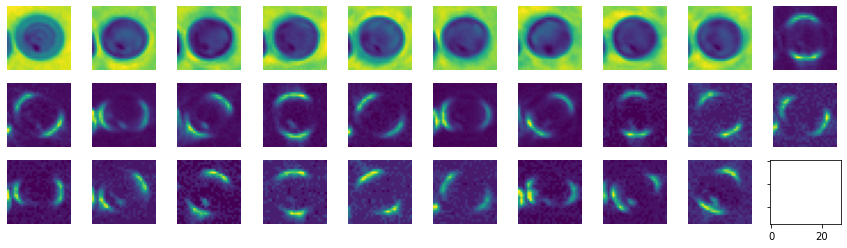

In [33]:
# label 0: normal cell, label 1: infected cell
# for i in range(29): # sample images in each channel
#     plt.figure()
#     plt.imshow(images[1000,:,:,i])
fig, axs = plt.subplots(3,10, sharex=True, sharey=True, figsize=(15,4))
for row in range(3):
  for col in range(10):
    index = row*10+col
    if index < 29:
      axs[row, col].imshow(images[1000,:,:,index])
      axs[row, col].axis('off')
plt.show()

In [0]:
original_im = torch.zeros((28,28))
for i in range(29):
  original_im += images[1000, :, :, i]

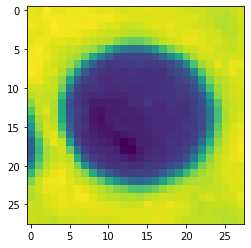

In [32]:
plt.imshow(original_im) # add up (green) 29 channels as the original image (truth)

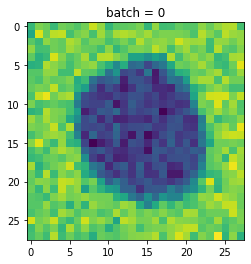

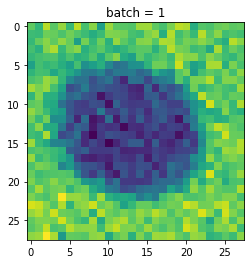

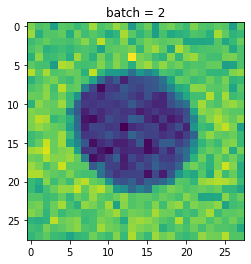

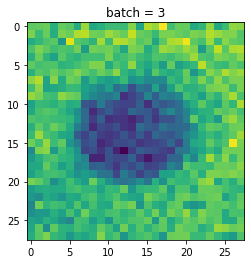

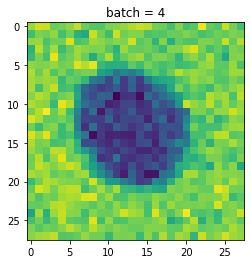

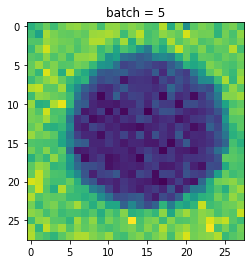

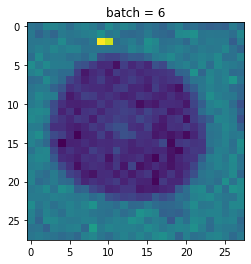

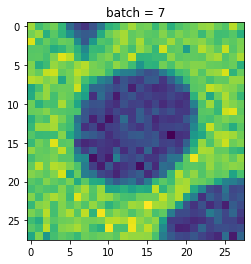

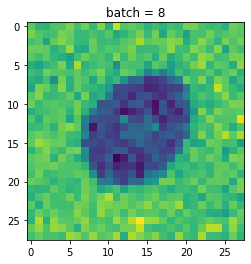

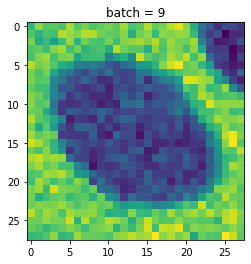

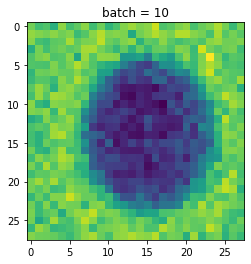

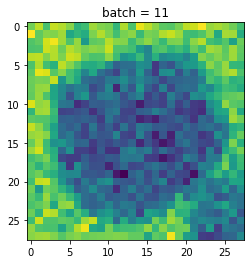

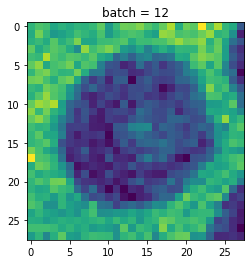

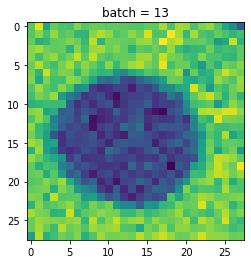

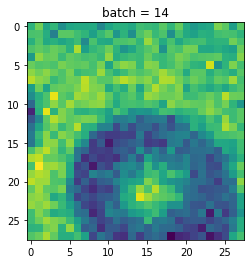

In [0]:
# generate noisy images (image in each channel has random gaussian noise in the same distribution)
for i,(images, labels) in enumerate(train_loader):
  mean = 0
  stddev = 0.05
  noise = np.random.normal(loc=mean, scale=stddev, size=np.shape(images))
  noise = torch.from_numpy(noise)
  noisy_image = images + noise
  sum_noisyim = torch.zeros((28,28))
  for j in range(29):
    sum_noisyim += noisy_image[i, :, :, j]
  plt.imshow(sum_noisyim)
  plt.title('batch = {}'.format(i))
  plt.show()

In [0]:
def sumImage_channels(image):
  sumIm = torch.zeros((image.shape[0],image.shape[2],image.shape[3]))
  for i in range(image.shape[1]):
    sumIm += image[:,i,:,:]
  return sumIm

In [0]:
def randomNoise(shape, stddev = 0.05):
    type = np.random.randint(0,1)
    if type == 0:
        noise = np.random.normal(loc = 0, scale = stddev, size = shape)
    else:
        noise = np.random.poisson(size = shape)
    noise = torch.from_numpy(noise)
    return noise

In [39]:
class UNet(nn.Module):
  def __init__(self, in_channels=29, out_channels=1):
    super(UNet, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    #physical layer
    # self.phyconv = nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=1, stride=1, padding=0) # same padding
    # Layers: enc_conv0, enc_conv1, pool1
    self._block1 = nn.Sequential(
        nn.Conv2d(1, 48, 3, stride=1, padding=1),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(48, 48, 3, padding=1),
        nn.LeakyReLU(0.1, inplace=True),
        nn.MaxPool2d(2))
    # Layers: enc_conv(i), pool(i); i=2..5
    self._block2 = nn.Sequential(
        nn.Conv2d(48, 48, 3, stride=1, padding=1),
        nn.LeakyReLU(0.1, inplace=True),
        nn.MaxPool2d(2))
    # Layers: enc_conv6, upsample5
    self._block3 = nn.Sequential(
        nn.Conv2d(48, 48, 3, stride=1, padding=1),
        nn.LeakyReLU(0.1, inplace=True),
        #nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
        nn.Upsample(scale_factor=2, mode='nearest'))
    # Layers: dec_conv5a, dec_conv5b, upsample4
    self._block4 = nn.Sequential(
        nn.Conv2d(96, 96, 3, stride=1, padding=1),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(96, 96, 3, stride=1, padding=1),
        nn.LeakyReLU(0.1, inplace=True),
        #nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        nn.Upsample(scale_factor=2, mode='nearest'))
    # Layers: dec_deconv(i)a, dec_deconv(i)b, upsample(i-1); i=4..2
    self._block5 = nn.Sequential(
        nn.Conv2d(144, 96, 3, stride=1, padding=1),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(96, 96, 3, stride=1, padding=1),
        nn.LeakyReLU(0.1, inplace=True),
        #nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        nn.Upsample(scale_factor=2, mode='nearest'))
    # Layers: dec_conv1a, dec_conv1b, dec_conv1c,
    self._block6 = nn.Sequential(
        nn.Conv2d(96 + 1, 64, 3, stride=1, padding=1),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(64, 32, 3, stride=1, padding=1),
        nn.LeakyReLU(0.1, inplace=True),    
        nn.Conv2d(32, out_channels, 3, stride=1, padding=1))
    # Initialize weights
    self._init_weights()
  def _init_weights(self):
    for m in self.modules():
        if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            m.bias.data.zero_()
  def physicalLayer(self, X):
        noise = randomNoise(X.shape).float()
        y = X + noise
        return y
  def forward(self, x):
    # Encoder
    # physical0 = self.phyconv(x)
    pool1 = self._block1(x)
    pool2 = self._block2(pool1)
    # pool3 = self._block2(pool2)
    # pool4 = self._block2(pool3)
    # pool5 = self._block2(pool4)
    # Decoder
    # upsample5 = self._block3(pool5)
    # concat5 = torch.cat((upsample5, pool4), dim=1)
    # upsample4 = self._block4(concat5)
    # concat4 = torch.cat((upsample4, pool3), dim=1)
    # upsample3 = self._block5(concat4)
    # concat3 = torch.cat((upsample3, pool2), dim=1)
    # upsample2 = self._block5(concat3)
    # concat2 = torch.cat((upsample2, pool1), dim=1)
    # upsample1 = self._block5(concat2)
    # concat1 = torch.cat((upsample1, x), dim=1)
    upsample2 = self._block3(pool2)
    concat2 = torch.cat((upsample2, pool1), dim=1)
    upsample1 = self._block4(concat2)
    concat1 = torch.cat((upsample1, x), dim=1)
    # print(concat1.shape)
    # Final activation
    return self._block6(concat1)

# initialize the NN
model = UNet().float()
print(model)
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

UNet(
  (_block1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_block2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_block3): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Upsample(scale_factor=2.0, mode=nearest)
  )
  (_block4): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Conv2d(96, 96, k

In [40]:
loss_list = []
n_epochs = 50
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
      images = images.permute(0,3,1,2)
      real_img = torch.sum(images, dim = 1, keepdim = True) # truth image, one channel
      Physical_img = model.physicalLayer(images) # noisy image
      noisy_img = torch.sum(Physical_img, dim = 1, keepdim = True) #noisy image, one channel
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model.forward(noisy_img.float())      
      # print(outputs.dtype)
      # calculate the loss
      loss = criterion(output, real_img)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update running training loss
      train_loss += loss.item()*images.size(0)
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    loss_list.append(train_loss)
    print('Epoch: {}  Train Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))
                
   

Epoch: 1  Train Loss: 294.612369
Epoch: 2  Train Loss: 13.816380
Epoch: 3  Train Loss: 6.364356
Epoch: 4  Train Loss: 4.205849
Epoch: 5  Train Loss: 3.270533
Epoch: 6  Train Loss: 2.803171
Epoch: 7  Train Loss: 2.491598
Epoch: 8  Train Loss: 2.281769
Epoch: 9  Train Loss: 2.127433
Epoch: 10  Train Loss: 1.996582
Epoch: 11  Train Loss: 1.899940
Epoch: 12  Train Loss: 1.817884
Epoch: 13  Train Loss: 1.747484
Epoch: 14  Train Loss: 1.678818
Epoch: 15  Train Loss: 1.632659
Epoch: 16  Train Loss: 1.584794
Epoch: 17  Train Loss: 1.536416
Epoch: 18  Train Loss: 1.508422
Epoch: 19  Train Loss: 1.476912
Epoch: 20  Train Loss: 1.449805
Epoch: 21  Train Loss: 1.425677
Epoch: 22  Train Loss: 1.399030
Epoch: 23  Train Loss: 1.378681
Epoch: 24  Train Loss: 1.350680
Epoch: 25  Train Loss: 1.326038
Epoch: 26  Train Loss: 1.313895
Epoch: 27  Train Loss: 1.306979
Epoch: 28  Train Loss: 1.275554
Epoch: 29  Train Loss: 1.262149
Epoch: 30  Train Loss: 1.246429
Epoch: 31  Train Loss: 1.240899
Epoch: 32  Tra

Text(0.5, 1.0, 'Training Loss (UNet without physical layer optimization)')

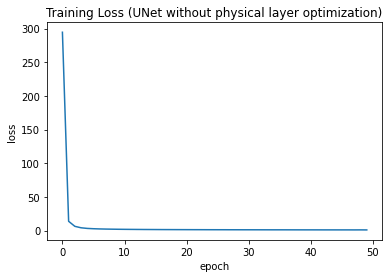

In [41]:
plt.figure()
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training Loss (UNet without physical layer optimization)')

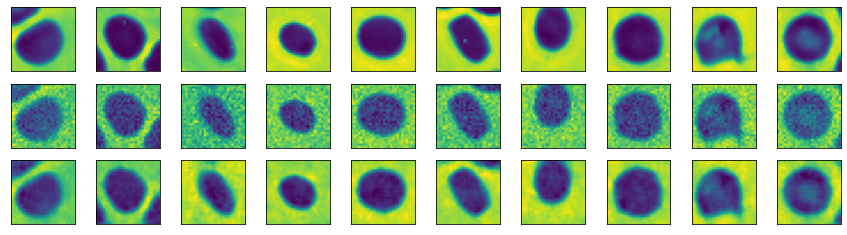

In [43]:
real_img = real_img.detach().numpy()
noisy_img = noisy_img.detach().numpy()
output = output.detach().numpy()
test_images = real_img[0:10,:,:,:]
test_output = output[0:10,:,:,:]
test_noisy = noisy_img[0:10,:,:,:]
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(15,4))

# input images on top row, reconstructions on bottom
for images, row in zip([test_images, test_noisy, test_output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [44]:
test_loss = 0.0
with torch.no_grad():
  for i, (images, labels) in enumerate(test_loader):
      images = images.permute(0,3,1,2)
      real_img = torch.sum(images, dim = 1, keepdim = True) # truth image, one channel
      Physical_img = model.physicalLayer(images) # noisy image
      noisy_img = torch.sum(Physical_img, dim = 1, keepdim = True) #noisy image, one channel
      output = model.forward(noisy_img.float())
      loss = criterion(output, real_img)      
      test_loss += loss.item()*images.size(0)
              
  # print avg training statistics 
  test_loss = test_loss/len(test_loader)
  print('Testing Loss: {:.6f}'.format(
      test_loss
      ))



Testing Loss: 0.878982


(1, 1, 28, 28)


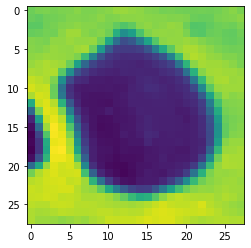

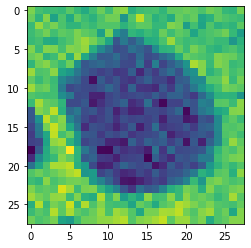

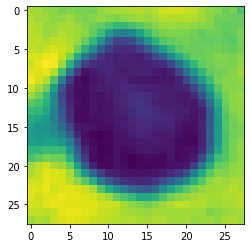

In [0]:
test_im = images[0:1,:,:,:]
test_phy = model.physicalLayer(test_im)
test_im_merge = torch.sum(test_im, dim = 1, keepdim = True)
test_im_merge = test_im_merge.detach().numpy()
print(test_im_merge.shape)
plt.imshow(test_im_merge[0,0,:,:])
plt.show()
test_phy_merge = torch.sum(test_phy, dim = 1, keepdim = True)
test_phy_image = test_phy_merge.detach().numpy()
plt.imshow(test_phy_merge[0,0,:,:])
plt.show()

denoised_im = model.forward(test_phy)
denoised_im = denoised_im.detach().numpy()
plt.imshow(denoised_im[0,0,:,:])
plt.show()
